# Skin Disease Detection using Mobile Application
## Final Year Project 2
Ahmad Daniel Ikhwan Bin Rosli <br>
1201103071

### Load dataset

In [1]:
import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


In [ ]:
# kaggle.json path
os.environ['PATH'] += os.pathsep + r'C:\Users\ADMIN\AppData\Roaming\Microsoft\Windows\Recent\kaggle.json.lnk'

In [ ]:
# download dataset
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification -p datasets/ham10000_raw --unzip

Dataset URL: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification


  0%|          | 0.00/2.59G [00:00<?, ?B/s]
  3%|▎         | 70.0M/2.59G [00:00<00:03, 691MB/s]
  6%|▌         | 152M/2.59G [00:00<00:03, 757MB/s] 
  8%|▊         | 225M/2.59G [00:00<00:04, 631MB/s]
 11%|█         | 288M/2.59G [00:00<00:03, 640MB/s]
 13%|█▎        | 351M/2.59G [00:00<00:04, 547MB/s]
 16%|█▌        | 422M/2.59G [00:00<00:03, 597MB/s]
 18%|█▊        | 482M/2.59G [00:00<00:03, 573MB/s]
 20%|██        | 539M/2.59G [00:00<00:03, 577MB/s]
 22%|██▏       | 596M/2.59G [00:01<00:03, 544MB/s]
 25%|██▍       | 659M/2.59G [00:01<00:04, 494MB/s]
 27%|██▋       | 718M/2.59G [00:01<00:03, 525MB/s]
 29%|██▉       | 777M/2.59G [00:01<00:03, 550MB/s]
 31%|███▏      | 831M/2.59G [00:01<00:03, 511MB/s]
 33%|███▎      | 886M/2.59G [00:01<00:03, 528MB/s]
 35%|███▌      | 941M/2.59G [00:01<00:03, 541MB/s]
 37%|███▋      | 994M/2.59G [00:01<00:03, 501MB/s]
 40%|███▉      | 1.02G/2.59G [00:01<00:03, 518MB/s]
 42%|████▏     | 1.08G/2.59G [00:02<00:03, 527MB/s]
 43%|████▎     | 1.12G/2.59G [00:


License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)



In [2]:
# create label
df = pd.read_csv("datasets/ham10000_raw/GroundTruth.csv")
df["label"] = df[["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]].idxmax(axis=1).str.lower()
df = df[df["label"].isin(["mel", "nv", "bcc", "akiec", "bkl"])].reset_index(drop=True)
df["file_path"] = df["image"].apply(lambda x: f"datasets/ham10000_raw/images/{x}.jpg")
df_drop = df.drop(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"], axis=1)


In [3]:
df_drop.head()

,label,file_path
0,nv,datasets/ham10000_raw/images/ISIC_0024306.jpg
1,nv,datasets/ham10000_raw/images/ISIC_0024307.jpg
2,nv,datasets/ham10000_raw/images/ISIC_0024308.jpg
3,nv,datasets/ham10000_raw/images/ISIC_0024309.jpg
4,mel,datasets/ham10000_raw/images/ISIC_0024310.jpg


In [4]:
# count total for each target class
df["label"] = df["label"].str.lower()

target_classes = ["mel", "nv", "bcc", "bkl", "akiec"]

df = df[df["label"].isin(target_classes)].reset_index(drop=True)

df["label"].value_counts()

label
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
Name: count, dtype: int64

### Phase 1 Prep

In [10]:
# targeted data augmentation and save it
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

augmentation_plan = {
    "mel": 6,
    "bkl": 6,
    "bcc": 12,
    "akiec": 20
}

augmented_dir = Path("datasets/ham10000_augmented")
augmented_dir.mkdir(parents=True, exist_ok=True)

for label, times in augmentation_plan.items():
    subset = df[df["label"] == label]
    save_folder = augmented_dir / label
    save_folder.mkdir(parents=True, exist_ok=True)
    for _, row in subset.iterrows():
        img = load_img(row["file_path"])
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        gen = aug.flow(img_array, batch_size=1)
        for i in range(times):
            aug_img = next(gen)[0].astype(np.uint8)
            save_img(save_folder / f"{row['image']}_aug{i}.jpg", aug_img)


In [11]:
# copy original + augmented to phase1_prepared/skin_disease/
phase1_path = Path("datasets/phase1_prepared/skin_disease")
phase1_path.mkdir(parents=True, exist_ok=True)

for _, row in df.iterrows():
    shutil.copy(row["file_path"], phase1_path / f"{row['image']}.jpg")

for label in augmentation_plan:
    for f in (augmented_dir / label).glob("*.jpg"):
        shutil.copy(f, phase1_path / f.name)

In [12]:
# splitting to 80 10 10
image_paths = list(phase1_path.glob("*.jpg"))

df_phase1 = pd.DataFrame({
    "file_path": image_paths,
    "label": ["skin"] * len(image_paths)
})

train_df, temp_df = train_test_split(df_phase1, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

split_data = [("train", train_df), ("val", val_df), ("test", test_df)]
for split_name, split_df in split_data:
    out_dir = Path(f"datasets/phase1_prepared/{split_name}/skin")
    out_dir.mkdir(parents=True, exist_ok=True)
    for _, row in split_df.iterrows():
        shutil.copy(row["file_path"], out_dir / row["file_path"].name)

print("Done splitting and copying Phase 1 dataset.")

Done splitting and copying Phase 1 dataset.


### Phase 1 Trian Model

In [6]:
# create dataloaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
base_dir = Path("datasets/phase1_prepared")

train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 28590 images belonging to 1 classes.
Found 3574 images belonging to 1 classes.
Found 3574 images belonging to 1 classes.


In [57]:
# mobilenet
print("Training MobileNet Phase 1...")

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.save("mobilenet_base_no_top.h5")

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

history_mobilenet_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)

model.save("mobilenet_phase1_binary.h5")
K.clear_session()

Training MobileNet Phase 1...
Epoch 1/50
894/894 [==============================] - 122s 135ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 1.7989e-05 - val_accuracy: 1.0000
Epoch 2/50
894/894 [==============================] - 109s 122ms/step - loss: 9.5024e-06 - accuracy: 1.0000 - val_loss: 4.4349e-06 - val_accuracy: 1.0000
Epoch 3/50
894/894 [==============================] - 101s 113ms/step - loss: 2.9360e-06 - accuracy: 1.0000 - val_loss: 1.7365e-06 - val_accuracy: 1.0000
Epoch 4/50
894/894 [==============================] - 96s 108ms/step - loss: 1.2561e-06 - accuracy: 1.0000 - val_loss: 8.2501e-07 - val_accuracy: 1.0000
Epoch 5/50
894/894 [==============================] - 96s 108ms/step - loss: 6.1748e-07 - accuracy: 1.0000 - val_loss: 4.2833e-07 - val_accuracy: 1.0000
Epoch 6/50
894/894 [==============================] - 96s 108ms/step - loss: 3.2829e-07 - accuracy: 1.0000 - val_loss: 2.3834e-07 - val_accuracy: 1.0000
Epoch 7/50
894/894 [==============================] -

In [58]:
# mobilenetv2
print("Training MobileNetV2 Phase 1...")

base_model_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model_v2.save("mobilenetv2_base_no_top.h5")

x = GlobalAveragePooling2D()(base_model_v2.output)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model_v2 = Model(inputs=base_model_v2.input, outputs=preds)

for layer in base_model_v2.layers:
    layer.trainable = False

model_v2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

history_mobilenetv2_phase1 = model_v2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)

model_v2.save("mobilenetv2_phase1_binary.h5")
K.clear_session()

Training MobileNetV2 Phase 1...
Epoch 1/50
894/894 [==============================] - 101s 110ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 2.6428e-05 - val_accuracy: 1.0000
Epoch 2/50
894/894 [==============================] - 98s 110ms/step - loss: 1.4322e-05 - accuracy: 1.0000 - val_loss: 6.8258e-06 - val_accuracy: 1.0000
Epoch 3/50
894/894 [==============================] - 100s 112ms/step - loss: 4.7422e-06 - accuracy: 1.0000 - val_loss: 2.8172e-06 - val_accuracy: 1.0000
Epoch 4/50
894/894 [==============================] - 100s 112ms/step - loss: 2.1559e-06 - accuracy: 1.0000 - val_loss: 1.3870e-06 - val_accuracy: 1.0000
Epoch 5/50
894/894 [==============================] - 101s 113ms/step - loss: 1.1190e-06 - accuracy: 1.0000 - val_loss: 7.4553e-07 - val_accuracy: 1.0000
Epoch 6/50
894/894 [==============================] - 102s 114ms/step - loss: 6.2152e-07 - accuracy: 1.0000 - val_loss: 4.2117e-07 - val_accuracy: 1.0000
Epoch 7/50
894/894 [=============================

### Phase 1 Compare

In [7]:
# load model to compare
mobilenet = load_model("mobilenet_phase1_binary.h5")
mobilenetv2 = load_model("mobilenetv2_phase1_binary.h5")

test_loss_mn, test_acc_mn = mobilenet.evaluate(test_gen, verbose=0)
test_loss_mn2, test_acc_mn2 = mobilenetv2.evaluate(test_gen, verbose=0)

Text(0, 0.5, 'Accuracy')

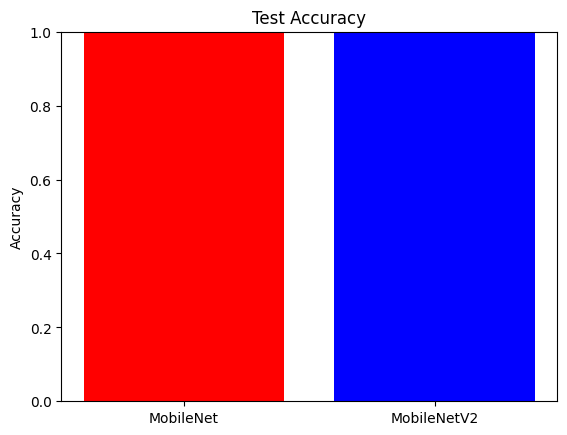

In [8]:
# accuracy
plt.bar(["MobileNet", "MobileNetV2"], [test_acc_mn, test_acc_mn2], color=["red", "blue"])
plt.title("Test Accuracy")
plt.ylim(0, 1)
plt.ylabel("Accuracy")


Text(0, 0.5, 'Loss')

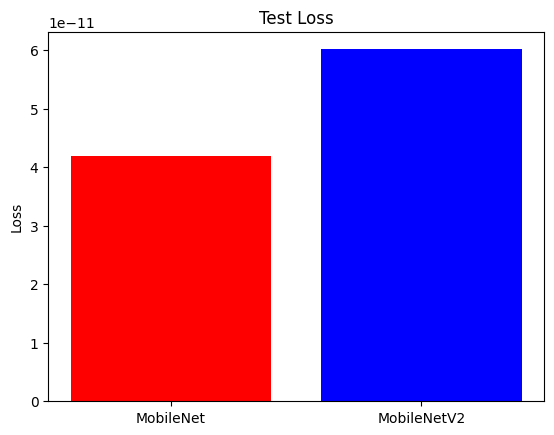

In [9]:
# loss
plt.bar(["MobileNet", "MobileNetV2"], [test_loss_mn, test_loss_mn2], color=["red", "blue"])
plt.title("Test Loss")
plt.ylabel("Loss")


### Phase 2 Prep

In [ ]:
augmented_dir = Path("datasets/ham10000_augmented")

augmented_image_paths = []
augmented_labels = []

for label_dir in augmented_dir.iterdir():
    if label_dir.is_dir():
        for img_path in label_dir.glob("*.jpg"):
            augmented_image_paths.append(img_path)
            augmented_labels.append(label_dir.name)

df_augmented = pd.DataFrame({
    "label": augmented_labels,
    "file_path": augmented_image_paths
})

print(f"Augmented data count per class:\n{df_augmented['label'].value_counts()}")

In [ ]:
df_drop["label"] = df_drop["label"].str.lower()

target_classes = ["nv"]

df_nv = df_drop[df_drop["label"].isin(target_classes)].reset_index(drop=True)

print(f"nv data count:\n{df_nv['label'].value_counts()}")

In [ ]:
df_augmented.head()

In [ ]:
df_nv.head()

In [ ]:
df_combined = pd.concat([df_nv, df_augmented], ignore_index=True)
print(df_combined['label'].value_counts())


In [ ]:
train_df, temp_df = train_test_split(df_combined, test_size=0.2, stratify=df_combined["label"], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

print("\nTrain Distribution:\n", train_df["label"].value_counts())
print("\nVal Distribution:\n", val_df["label"].value_counts())
print("\nTest Distribution:\n", test_df["label"].value_counts())

In [ ]:
# copy target classes to new directory
output_dir = Path("datasets/phase2_prepared")
splits = [("train", train_df), ("val", val_df), ("test", test_df)]

for split_name, df_split in splits:
    for _, row in df_split.iterrows():
        label = row["label"]
        src = row["file_path"]
        dst = output_dir / split_name / label
        dst.mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dst / Path(src).name)

print("All images copied to datasets/phase2_prepared")

### Phase 2 Train Model

In [10]:
# create dataloaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
phase2_dir = Path("datasets/phase2_prepared")

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=phase2_dir / "train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",   
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    directory=phase2_dir / "val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=phase2_dir / "test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 26148 images belonging to 5 classes.
Found 3268 images belonging to 5 classes.
Found 3269 images belonging to 5 classes.


In [12]:
# mobilenet
print("Training MobileNet Phase 2...")

base_model = load_model("mobilenet_base_no_top.h5")

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
num_classes = len(train_gen.class_indices)  
preds = Dense(num_classes, activation='softmax')(x)

phase2_model = Model(inputs=base_model.input, outputs=preds)

for layer in base_model.layers:
    layer.trainable = False

phase2_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history_mobilenet_phase2 = phase2_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)

phase2_model.save("mobilenet_phase2_multiclass.h5")
K.clear_session()

Training MobileNet Phase 2...
Epoch 1/50
818/818 [==============================] - 338s 411ms/step - loss: 1.0232 - accuracy: 0.5938 - val_loss: 0.8215 - val_accuracy: 0.6870
Epoch 2/50
818/818 [==============================] - 161s 197ms/step - loss: 0.7341 - accuracy: 0.7193 - val_loss: 0.6927 - val_accuracy: 0.7338
Epoch 3/50
818/818 [==============================] - 161s 197ms/step - loss: 0.6320 - accuracy: 0.7650 - val_loss: 0.6281 - val_accuracy: 0.7580
Epoch 4/50
818/818 [==============================] - 161s 197ms/step - loss: 0.5649 - accuracy: 0.7920 - val_loss: 0.5839 - val_accuracy: 0.7794
Epoch 5/50
818/818 [==============================] - 161s 197ms/step - loss: 0.5136 - accuracy: 0.8154 - val_loss: 0.5426 - val_accuracy: 0.7944
Epoch 6/50
818/818 [==============================] - 161s 197ms/step - loss: 0.4751 - accuracy: 0.8315 - val_loss: 0.5098 - val_accuracy: 0.8143
Epoch 7/50
818/818 [==============================] - 161s 197ms/step - loss: 0.4385 - accurac

In [ ]:
# mobilenetV2
print("Training MobileNetV2 Phase 2...")

base_model_v2 = load_model("mobilenetv2_base_no_top1.h5")

x = GlobalAveragePooling2D()(base_model_v2.output)
x = Dense(128, activation='relu')(x)
num_classes = len(train_gen.class_indices)
preds = Dense(num_classes, activation='softmax')(x)

phase2_model_v2 = Model(inputs=base_model_v2.input, outputs=preds)

for layer in base_model_v2.layers:
    layer.trainable = False

phase2_model_v2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history_mobilenetv2_phase2 = phase2_model_v2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)

phase2_model_v2.save("mobilenetv2_phase2_multiclass.h5")
K.clear_session()
